<a href="https://colab.research.google.com/github/IndahPurnamaSarii/Klasifikasi-Tas/blob/main/Klasifikasi_Tas_Code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Resizing, Rescaling
from PIL import Image

from pathlib import Path
import os.path
import random
import datetime

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 16
TARGET_SIZE = (128, 128)

# Direktori dataset
dataset = "/content/drive/MyDrive/Dataset-Deeplearning"

# Menampilkan folder dan jumlah file didalam direktori
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(dirnames)} folder dan {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(dataset)

Ada 4 folder dan 0 file di direktori: /content/drive/MyDrive/Dataset-Deeplearning
Ada 0 folder dan 305 file di direktori: /content/drive/MyDrive/Dataset-Deeplearning/Koper
Ada 0 folder dan 600 file di direktori: /content/drive/MyDrive/Dataset-Deeplearning/Tas-Ransel
Ada 0 folder dan 335 file di direktori: /content/drive/MyDrive/Dataset-Deeplearning/Tas-Jinjing
Ada 0 folder dan 565 file di direktori: /content/drive/MyDrive/Dataset-Deeplearning/Tas-Samping


In [ ]:
image_dir = Path(dataset)

# Mengambil jalur file dan label
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Menyatukan jalur file dan label
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-6-cb9b16ca644a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


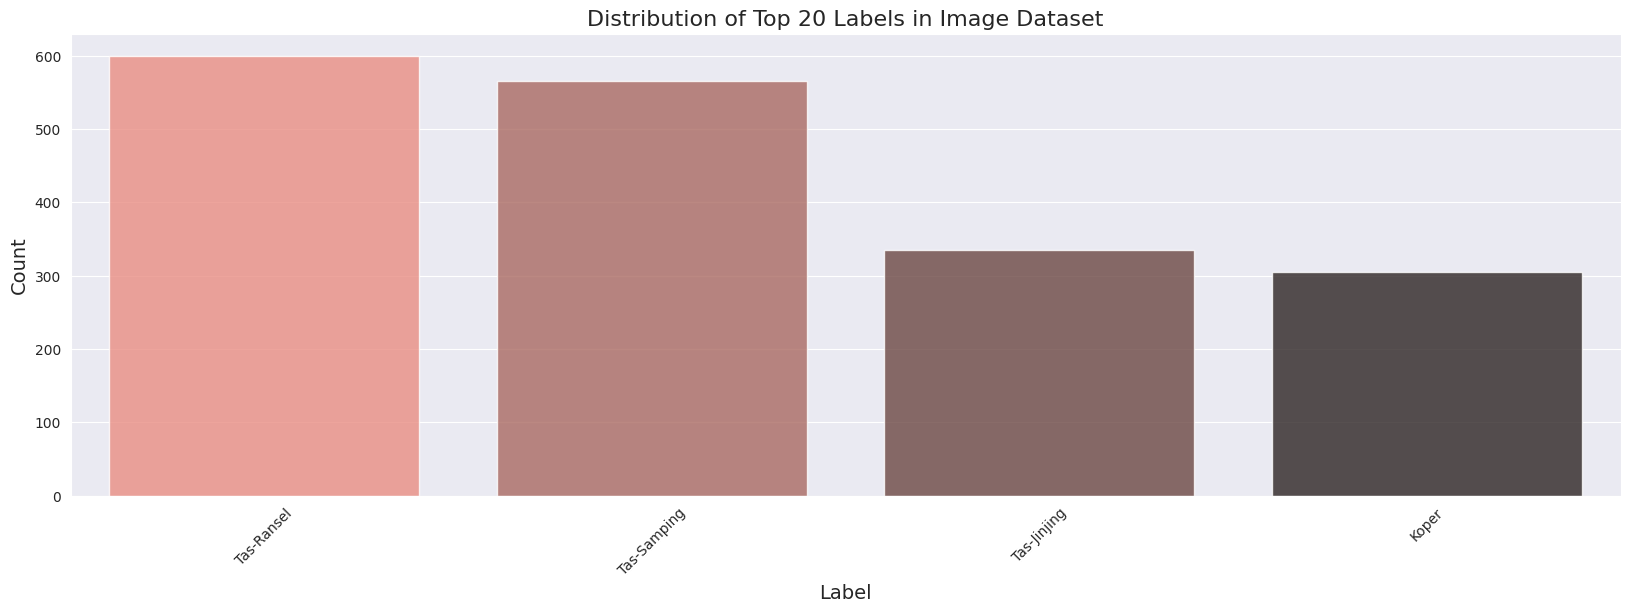

In [ ]:
# Ekstrak 20 label terbaik
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

<ipython-input-7-81370adc42e6>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)


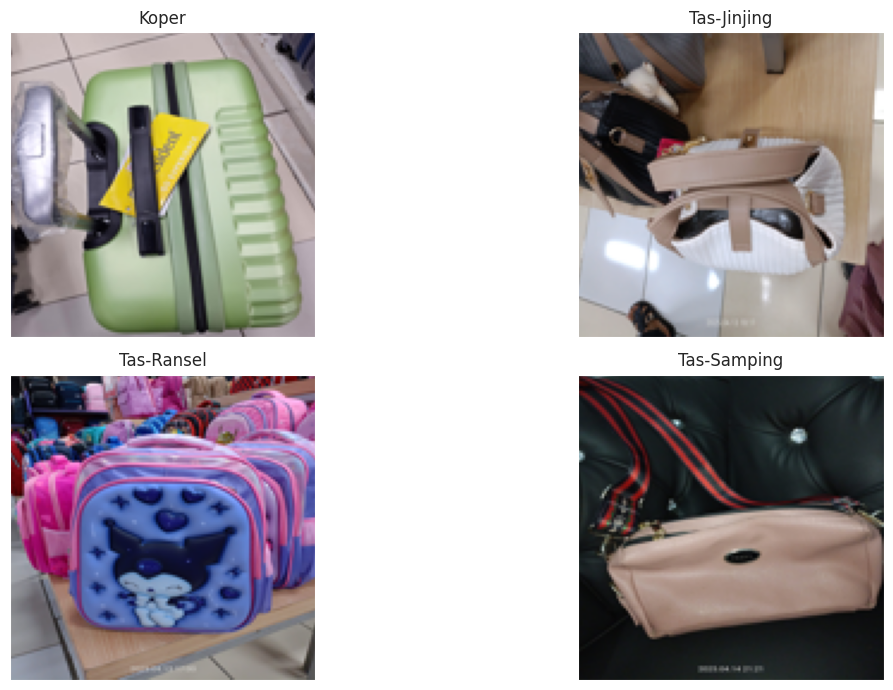

In [ ]:
# Mengambil 1 sampel gambar secara acak dari setiap kelas yang ada dalam dataset
sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)

# Menyiapkan jumlah subplots sesuai dengan jumlah kelas yang ada (jumlah kelas = len(sample_df))
# Misalkan kita punya maksimal 8 kelas yang ingin ditampilkan, pastikan jumlah kelas sesuai.
num_classes = len(sample_df)
rows = 2
cols = (num_classes // rows) + (num_classes % rows)

# Menyiapkan grid plot sesuai jumlah kelas yang ada
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})

# Meratakan axes menjadi array agar bisa diproses lebih mudah
axes = axes.flatten()

# Menampilkan setiap gambar ke dalam subplot
for i, ax in enumerate(axes[:num_classes]):  # Hanya tampilkan sebanyak jumlah kelas
    img_path = sample_df.Filepath.iloc[i]    # Mengambil path gambar dari dataframe
    label = sample_df.Label.iloc[i]          # Mengambil label kelas dari dataframe

    # Membuka gambar dari path dan mengubah ukurannya menjadi 128x128 piksel
    img = Image.open(img_path)
    img_resized = img.resize((128, 128))

    # Menampilkan gambar ke dalam subplot
    ax.imshow(img_resized)
    ax.set_title(label)  # Menambahkan judul sesuai label gambar

# Menyusun layout agar tidak tumpang tindih dan lebih rapi
plt.tight_layout()
plt.show()


In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15

    # Membaca gambar asli menggunakan OpenCV (format BGR secara default)
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB

    # Simpan gambar ke file JPEG dengan kualitas tertentu (menginduksi kompresi)
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Membaca kembali gambar hasil kompresi
    compressed_img = cv2.imread(temp_filename)

    # Hitung perbedaan absolut antara gambar asli dan hasil kompresi, lalu skala
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)

    return diff
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'

    # Membuka gambar asli dan mengonversinya ke format RGB
    image = Image.open(path).convert('RGB')

    # Simpan ulang gambar ke format JPEG dengan kualitas yang ditentukan
    image.save(temp_filename, 'JPEG', quality=quality)

    # Buka ulang gambar hasil kompresi
    temp_image = Image.open(temp_filename)

    # Hitung perbedaan antara gambar asli dan hasil kompresi menggunakan ImageChops
    ela_image = ImageChops.difference(image, temp_image)

    # Hitung nilai maksimum perbedaan piksel (extrema)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])  # Ambil nilai maksimum dari tiap channel

    # Jika tidak ada perbedaan, atur ke 1 untuk menghindari pembagian nol
    if max_diff == 0:
        max_diff = 1

    # Tingkatkan brightness untuk memperjelas perbedaan
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image
def random_sample(path, extension=None):
    # Memilih file gambar secara acak dari direktori tertentu
    if extension:
        items = Path(path).glob(f'*.{extension}')  # Filter berdasarkan ekstensi
    else:
        items = Path(path).glob(f'*')  # Ambil semua file

    items = list(items)  # Konversi dari generator ke list

    p = random.choice(items)  # Pilih satu file secara acak
    return p.as_posix()       # Kembalikan path dalam bentuk string POSIX


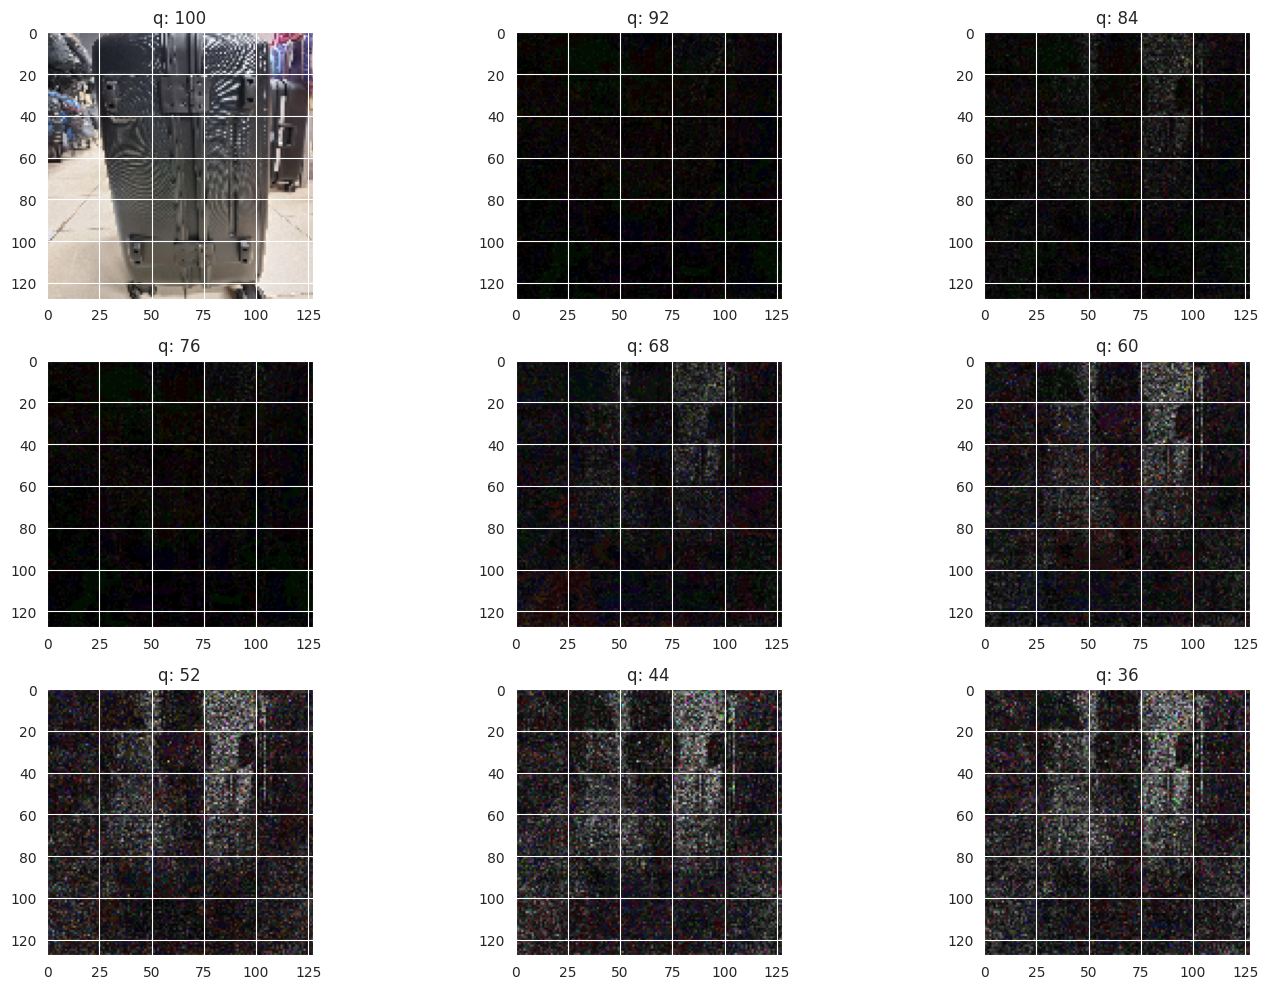

In [ ]:
# Menentukan kelas yang akan diambil sampel acak untuk ELA
sample_class = 'Koper'
dataset_path = '/content/drive/MyDrive/Dataset-Deeplearning'

# Ambil satu gambar acak dari folder kelas tersebut
p = random_sample(f'{dataset_path}/{sample_class}')

# Baca gambar asli dan ubah warnanya dari BGR (OpenCV default) ke RGB, serta normalisasi (0-1)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# Parameter awal untuk kualitas kompresi dan jumlah subplot
init_val = 100       # Nilai kualitas JPEG awal (maksimal)
columns = 3
rows = 3

# Inisialisasi figure untuk plotting grid 3x3
fig = plt.figure(figsize=(15, 10))

# Loop untuk membuat 9 gambar dengan tingkat kompresi berbeda
for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8  # Kualitas dikurangi setiap iterasi (100, 92, 84, dst.)

    # Gambar pertama ditampilkan sebagai gambar asli (tanpa ELA)
    if i == 1:
        img = orig.copy()
    else:
        img = compute_ela_cv(path=p, quality=quality)  # ELA dengan OpenCV

    # Resize gambar agar ukuran konsisten di grid (misalnya 128x128 piksel)
    img_resized = cv2.resize(img, (128, 128))

    # Tambahkan gambar ke subplot grid
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')  # Menampilkan kualitas JPEG pada judul subplot
    plt.imshow(img_resized)

# Tata letak subplot agar tidak saling menimpa
plt.tight_layout()
plt.show()


In [ ]:
# Membagi dataset menjadi data latih+validasi (90%) dan data uji (10%) secara stratified (proporsi label tetap)
train_val_df, test_df = train_test_split(
    image_df,
    test_size=0.10,
    shuffle=True,
    random_state=42,
    stratify=image_df['Label']
)

# Membagi data latih+validasi menjadi data latih (≈60%) dan data validasi (≈30%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=1/3,               # 1/3 dari 90% = 30%
    shuffle=True,
    random_state=42,
    stratify=train_val_df['Label']
)

# Menampilkan jumlah sampel pada setiap subset
print(f"Jumlah data latih: {len(train_df)}")
print(f"Jumlah data validasi: {len(val_df)}")
print(f"Jumlah data uji: {len(test_df)}")


Jumlah data latih: 1082
Jumlah data validasi: 542
Jumlah data uji: 181


In [ ]:
# Membuat image data generator untuk data pelatihan
# Preprocessing menggunakan fungsi dari MobileNetV2 (normalisasi sesuai standar pretrained model)
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Generator untuk data validasi (menggunakan preprocessing yang sama)
val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Generator untuk data pengujian (tidak dilakukan augmentasi, hanya preprocessing)
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [ ]:
# Membuat data generator untuk data pelatihan
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,              # DataFrame yang berisi file path dan label
    x_col='Filepath',                # Kolom yang berisi path gambar
    y_col='Label',                   # Kolom yang berisi label (kelas)
    target_size=TARGET_SIZE,         # Ukuran gambar yang diubah (misalnya: (128, 128))
    color_mode='rgb',                # Gambar berwarna (RGB)
    class_mode='categorical',        # Label dikonversi menjadi one-hot encoded
    batch_size=BATCH_SIZE,           # Jumlah gambar per batch
    shuffle=True,                    # Acak data setiap epoch
    seed=42                          # Seed untuk memastikan hasil bisa direproduksi
)

# Membuat data generator untuk data validasi
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk data pengujian
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False                  # Tidak diacak agar urutan prediksi konsisten untuk evaluasi
)


Found 1082 validated image filenames belonging to 4 classes.
Found 542 validated image filenames belonging to 4 classes.
Found 181 validated image filenames belonging to 4 classes.


In [ ]:
# Membuat pipeline augmentasi data menggunakan Keras Sequential API
augment = tf.keras.Sequential([
    layers.Resizing(128, 128),            # Mengubah ukuran semua gambar ke 128x128 piksel
    layers.Rescaling(1./255),             # Normalisasi piksel dari [0, 255] ke [0, 1]
    layers.RandomFlip("horizontal"),      # Membalik gambar secara horizontal secara acak
    layers.RandomRotation(0.4),           # Rotasi gambar acak hingga 40% dari 360 derajat
    layers.RandomZoom(0.4),               # Zoom acak pada gambar hingga 40%
    layers.RandomContrast(0.4),           # Variasi kontras secara acak hingga 40%
    layers.RandomTranslation(0.2, 0.2),   # Translasi acak secara horizontal dan vertikal hingga 20%
])


In [ ]:
# Memuat arsitektur MobileNetV2 sebagai feature extractor (tanpa top layer)
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),     # Ukuran input sesuai dengan yang ditentukan sebelumnya
    include_top=False,            # Tidak menyertakan fully connected layer di akhir (diganti dengan custom classifier)
    weights='imagenet',           # Menggunakan bobot pretrained dari dataset ImageNet
    pooling='max'                 # Menggunakan global max pooling pada output akhir convolution
)

# Membekukan semua layer pada model pretrained agar tidak dilatih ulang (transfer learning)
pretrained_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Membuat panggilan balik untuk menyimpan bobot model terbaik selama pelatihan
checkpoint_path = "Dataset-Deeplearning.weights.h5"  # Path untuk menyimpan bobot model terbaik
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,              # Path untuk menyimpan bobot
    save_weights_only=True,       # Hanya menyimpan bobot, bukan model lengkap
    monitor="val_accuracy",      # Monitor berdasarkan akurasi validasi
    save_best_only=True          # Hanya menyimpan bobot jika akurasi validasi meningkat
)

# Membuat panggilan balik EarlyStopping untuk menghentikan pelatihan jika val_loss tidak membaik selama 10 epoch
early_stopping = EarlyStopping(
    monitor="val_loss",          # Memantau validasi loss
    patience=10,                 # Menunggu 10 epoch jika tidak ada perbaikan
    restore_best_weights=True   # Mengembalikan bobot model ke titik terbaik jika pelatihan dihentikan lebih awal
)

# Membuat panggilan balik ReduceLROnPlateau untuk menurunkan laju pembelajaran jika val_loss tidak membaik
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Memantau validasi loss
    factor=0.2,                  # Menurunkan laju pembelajaran sebesar 20% jika tidak ada perbaikan
    patience=5,                  # Menunggu 5 epoch jika tidak ada perbaikan sebelum menurunkan lr
    min_lr=1e-6                  # Menentukan batas bawah untuk laju pembelajaran
)


In [ ]:
# Mendapatkan input dari model pretrained (MobileNetV2)
inputs = pretrained_model.input

# Menerapkan augmentasi data pada input gambar
x = augment(inputs)

# Menambahkan layer fully connected (Dense) setelah feature extractor
x = Dense(64, activation='relu')(pretrained_model.output)  # Layer dense pertama dengan 64 unit dan ReLU
x = Dropout(0.6)(x)  # Dropout untuk mencegah overfitting (60%)
x = Dense(256, activation='relu')(x)  # Layer dense kedua dengan 256 unit dan ReLU
x = Dropout(0.45)(x)  # Dropout lagi dengan 45%

# Layer output untuk klasifikasi, jumlah unitnya sesuai dengan jumlah kelas
outputs = Dense(len(train_images.class_indices), activation='softmax')(x)

# Membuat model baru dengan input dan output yang telah ditentukan
model = Model(inputs=inputs, outputs=outputs)

# Mengkompilasi model dengan optimizer Adam dan loss function categorical_crossentropy
model.compile(
    optimizer=Adam(0.00005),  # Optimizer Adam dengan learning rate kecil
    loss='categorical_crossentropy',  # Loss function untuk klasifikasi multi-kelas
    metrics=['accuracy']  # Metrik yang digunakan untuk evaluasi adalah akurasi
)

# Fungsi untuk membuat callback TensorBoard untuk memantau pelatihan
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir)

# Melatih model dengan data generator, menggunakan beberapa callback untuk kontrol pelatihan
history = model.fit(
    train_images,  # Data pelatihan
    steps_per_epoch=len(train_images),  # Menentukan jumlah langkah per epoch
    validation_data=val_images,  # Data validasi
    validation_steps=len(val_images),  # Menentukan jumlah langkah untuk validasi
    epochs=50,  # Jumlah epoch pelatihan
    callbacks=[  # Callback yang digunakan selama pelatihan
        early_stopping,  # Callback untuk menghentikan pelatihan lebih awal jika val_loss tidak membaik
        create_tensorboard_callback("training_logs", "Dataset-Deeplearning"),  # TensorBoard untuk visualisasi
        checkpoint_callback,  # Menyimpan bobot terbaik berdasarkan akurasi validasi
        reduce_lr  # Menurunkan learning rate jika val_loss tidak membaik
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1320s 19s/step - accuracy: 0.2735 - loss: 2.7006 - val_accuracy: 0.5461 - val_loss: 1.1366 - learning_rate: 5.0000e-05
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.3625 - loss: 1.7625 - val_accuracy: 0.6292 - val_loss: 1.0306 - learning_rate: 5.0000e-05
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.3776 - loss: 1.4710 - val_accuracy: 0.6956 - val_loss: 0.9831 - learning_rate: 5.0000e-05
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.4502 - loss: 1.2842 - val_accuracy: 0.7435 - val_loss: 0.9181 - learning_rate: 5.0000e-05
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.4784 - loss: 1.2057 - val_accuracy: 0.7768 - val_loss: 0.8621 - learning_rate: 5.0000e-05
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.5422 - loss: 1.1254 - val_accuracy: 0.8026 - val_loss: 0.7870 - learning_rate: 5.0000e-05
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.567

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06219
Test Accuracy: 97.79%


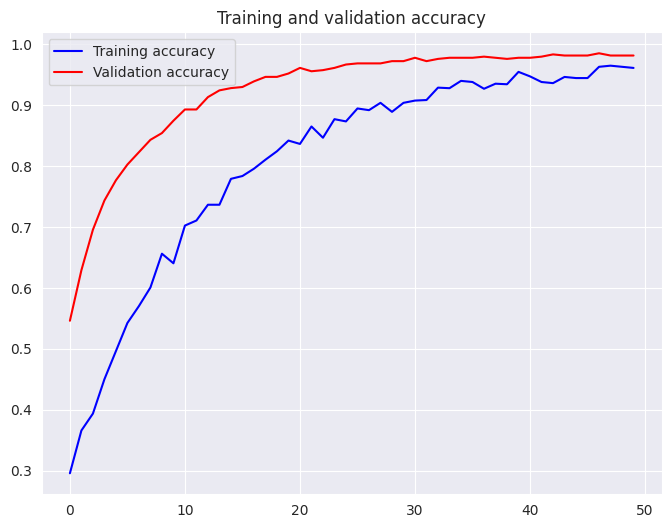

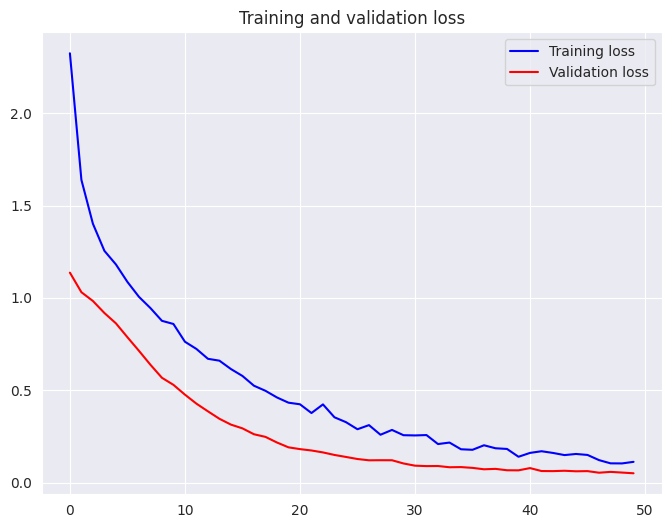

In [ ]:
# Mengambil data dari history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

# Plot akurasi
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Menampilkan grafik
plt.show()

In [ ]:
# Melakukan prediksi pada gambar uji (test_images) menggunakan model yang telah dilatih
pred = model.predict(test_images)  # Model akan menghasilkan probabilitas untuk setiap kelas
pred = np.argmax(pred, axis=1)  # Mengambil indeks kelas dengan probabilitas tertinggi (argmax)

# Memetakan label kelas ke nama kelas yang sesuai
labels = (train_images.class_indices)  # Mengambil dictionary kelas dan label dari generator data latih
labels = dict((v, k) for k, v in labels.items())  # Membalikkan dictionary untuk memetakan indeks ke nama kelas

# Mengonversi prediksi ke nama kelas yang sesuai
pred = [labels[k] for k in pred]  # Mengubah prediksi dari indeks kelas menjadi nama kelas

12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


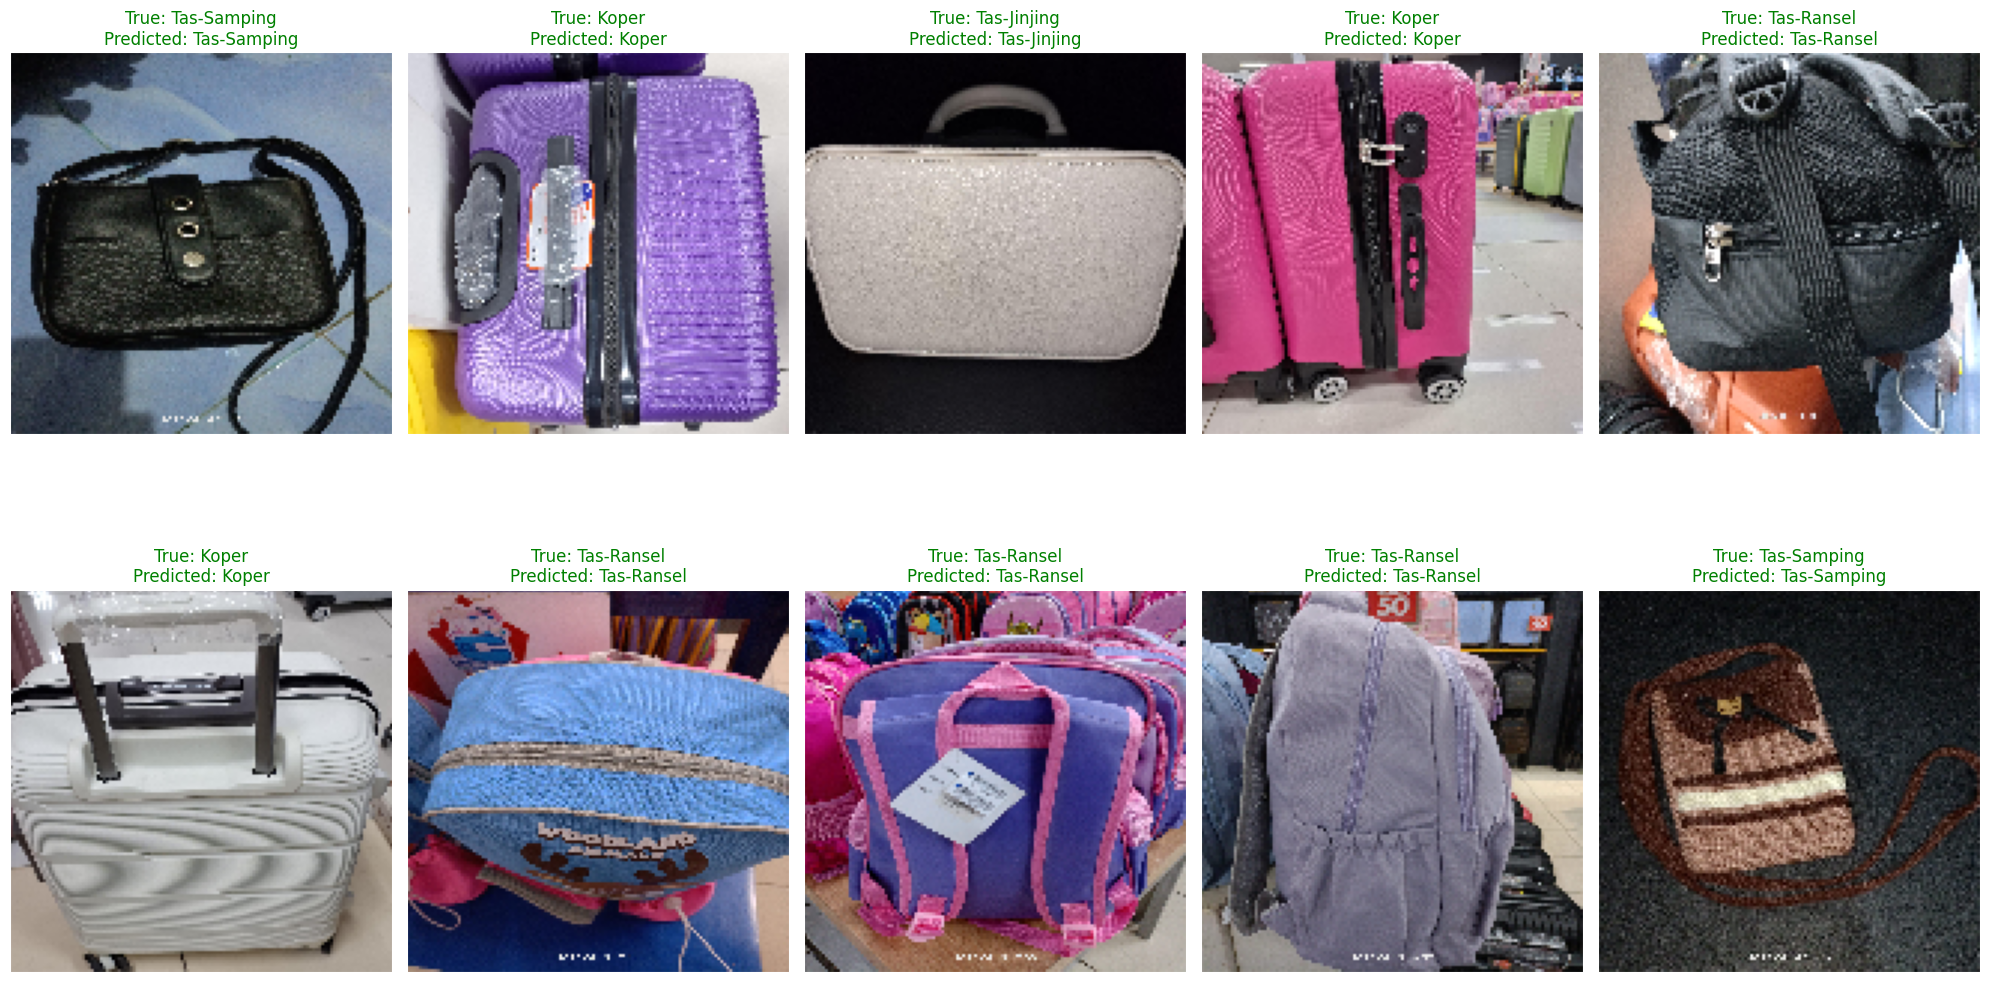

In [ ]:
# Menampilkan 10 gambar acak dari dataset dengan labelnya
random_index = np.random.randint(0, len(test_df) - 1, 10)  # Mengambil 10 gambar acak
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 12),  # Ukuran plot disesuaikan
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (128, 128)

for i, ax in enumerate(axes.flat):
    img = plt.imread(test_df.Filepath.iloc[random_index[i]])
    img_resized = cv2.resize(img, resize_dim)
    ax.imshow(img_resized)

    # Menentukan warna untuk judul berdasarkan apakah prediksi benar atau tidak
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"  # Prediksi benar
    else:
        color = "red"    # Prediksi salah

    # Menambahkan judul dengan label sebenarnya dan prediksi
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

# Mengatur layout agar gambar tidak tumpang tindih
plt.tight_layout()
plt.show()


In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       Koper       1.00      0.97      0.98        30
 Tas-Jinjing       1.00      0.91      0.95        34
  Tas-Ransel       0.98      1.00      0.99        60
 Tas-Samping       0.95      1.00      0.97        57

    accuracy                           0.98       181
   macro avg       0.98      0.97      0.98       181
weighted avg       0.98      0.98      0.98       181



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Koper          1.000000  0.966667  0.983051   30.000000
Tas-Jinjing    1.000000  0.911765  0.953846   34.000000
Tas-Ransel     0.983607  1.000000  0.991736   60.000000
Tas-Samping    0.950000  1.000000  0.974359   57.000000
accuracy       0.977901  0.977901  0.977901    0.977901
macro avg      0.983402  0.969608  0.975748  181.000000
weighted avg   0.978820  0.977901  0.977707  181.000000

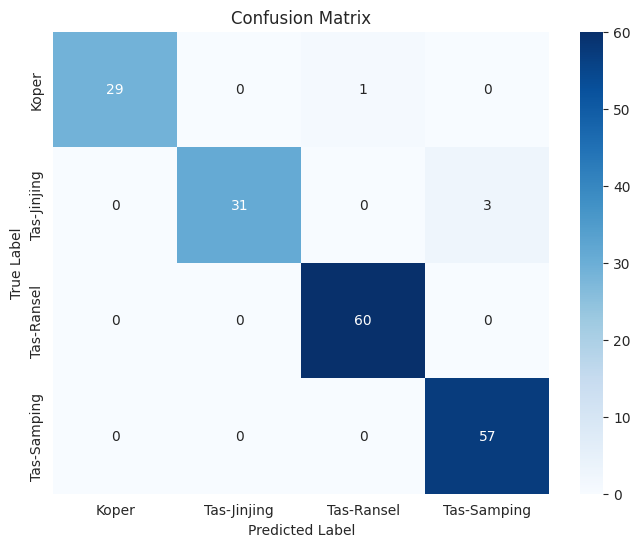

In [ ]:
# Menghitung matriks kebingungannya (confusion matrix) antara label sebenarnya dan prediksi
cm = confusion_matrix(y_test, pred)

# Membuat plot confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))  # Menentukan ukuran gambar untuk plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Heatmap dengan anotasi angka pada setiap sel, format desimal ('d')
            xticklabels=test_images.class_indices.keys(),  # Menampilkan nama kelas pada sumbu X (prediksi)
            yticklabels=test_images.class_indices.keys())  # Menampilkan nama kelas pada sumbu Y (label sebenarnya)

# Menambahkan judul, label sumbu X dan Y pada plot
plt.title('Confusion Matrix')  # Judul plot
plt.xlabel('Predicted Label')  # Label sumbu X untuk prediksi
plt.ylabel('True Label')  # Label sumbu Y untuk label sebenarnya

# Menampilkan plot
plt.show()

In [ ]:
def get_img_array(img_path, size):
    # Memuat gambar dari path yang diberikan dan mengubah ukurannya sesuai ukuran yang ditentukan
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # Menambahkan dimensi batch ke array untuk menyesuaikan format input model
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Membuat model baru yang menghubungkan input gambar dengan output dari layer konvolusi terakhir dan output prediksi
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Menggunakan GradientTape untuk menghitung gradien dari output prediksi kelas terhadap aktivasi layer konvolusi terakhir
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # Jika tidak ada indeks prediksi yang diberikan, ambil indeks kelas dengan probabilitas tertinggi
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # Menghitung gradien untuk kelas yang dipilih atau kelas dengan prediksi tertinggi
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Menghitung intensitas rata-rata gradien untuk setiap channel feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Mengalikan setiap channel dalam feature map dengan skor pentingnya channel tersebut untuk kelas yang diprediksi
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalisasi heatmap untuk visualisasi, agar berada dalam rentang 0 hingga 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Memuat gambar asli dari path yang diberikan
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Mengubah skala heatmap ke rentang 0 hingga 255
    heatmap = np.uint8(255 * heatmap)

    # Menggunakan colormap 'jet' untuk memberikan warna pada heatmap
    jet = cm.get_cmap("jet")

    # Mengambil nilai RGB dari colormap dan menerapkan pada heatmap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Mengubah heatmap ke ukuran gambar asli
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Menggabungkan gambar asli dengan heatmap yang diberi warna
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Menyimpan gambar hasil gabungan tersebut
    superimposed_img.save(cam_path)

    # Menampilkan Grad CAM
    # display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (128,128, 3)

# Menghapus fungsi aktivasi softmax dari layer terakhir model
model.layers[-1].activation = None

<ipython-input-24-24fb1cfdbf5f>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


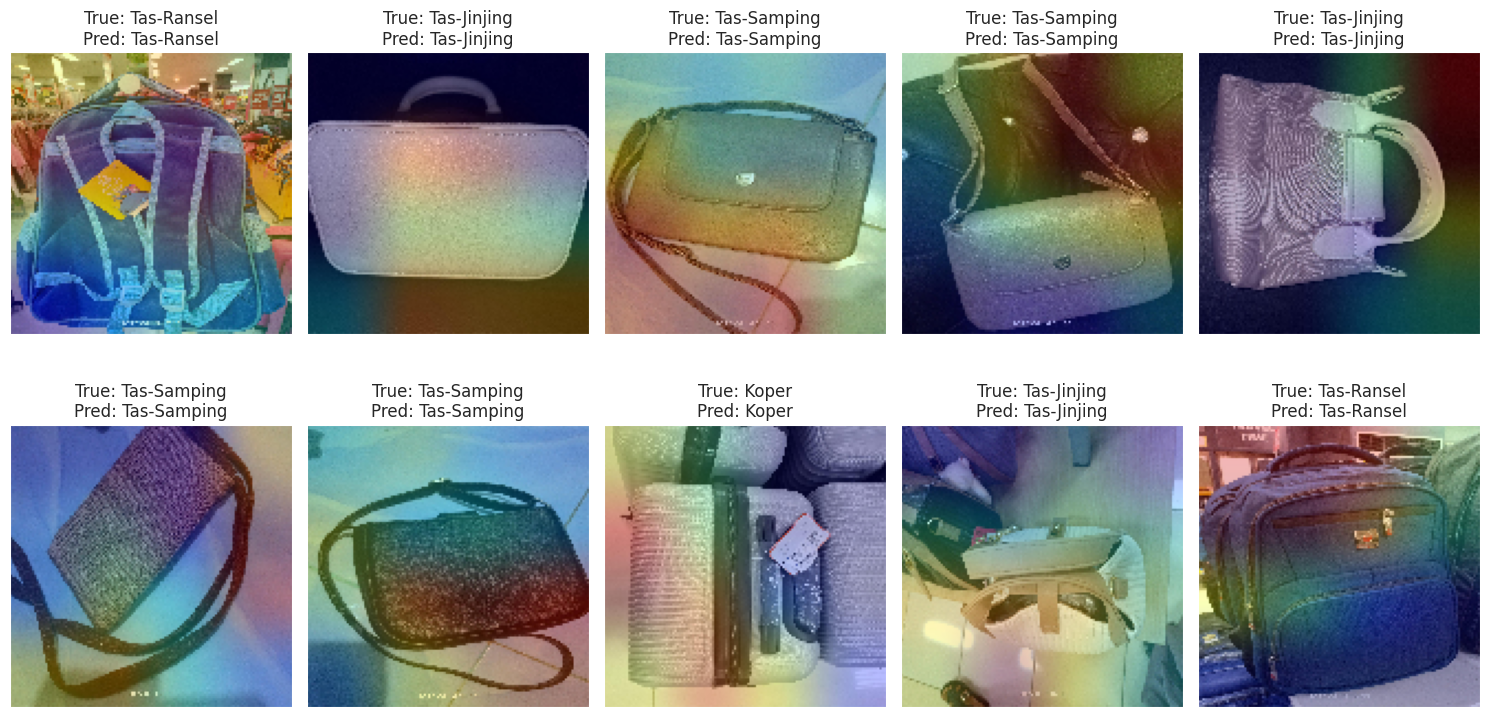

In [ ]:
import matplotlib.cm as cm

# Ambil 10 indeks acak dari test_df
random_index = np.random.randint(0, len(test_df), 10)

# Tampilkan 10 gambar (2x5 grid)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (128, 128)

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)

    img_resized = cv2.resize(plt.imread(cam_path), resize_dim)

    ax.imshow(img_resized)
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPred: {pred[random_index[i]]}")

plt.tight_layout()
plt.show()


In [ ]:
# Cek Data Baru
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


In [ ]:
def predict_new_image(image_path, model, class_indices):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=1)[0]

    # Buat mapping dari indeks ke label
    label_map = {v: k for k, v in class_indices.items()}
    predicted_label = label_map[predicted_index]

    # Tampilkan gambar & hasil prediksi
    plt.imshow(image.load_img(image_path))
    plt.title(f"Hasil Prediksi: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


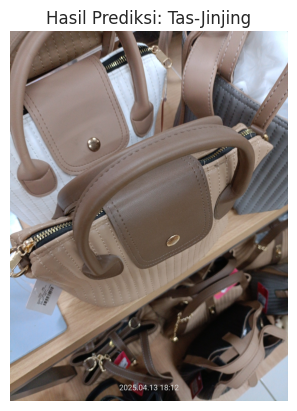

Hasil Prediksi: Tas-Jinjing


In [ ]:
image_path = "/content/drive/MyDrive/Auuu.jpg"
hasil_prediksi = predict_new_image(image_path, model, train_images.class_indices)

print(f"Hasil Prediksi: {hasil_prediksi}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


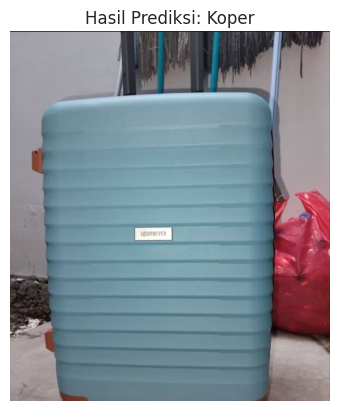

Hasil Prediksi: Koper


In [ ]:
image_path = "/content/drive/MyDrive/Tes-foto2.jpg"
hasil_prediksi = predict_new_image(image_path, model, train_images.class_indices)

print(f"Hasil Prediksi: {hasil_prediksi}")